### Libraries import

In [116]:
# import the libraries you need
import glob
from PIL import Image
import numpy as np
import pandas as pd
import sys
import os
import csv
import natsort
from PIL import Image 
from skimage.io import imread
from resizeimage import resizeimage 
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
earlystopper = EarlyStopping(patience=5, verbose=1)
import tensorflow as tf
from keras.layers import Conv2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from scipy.spatial.distance import directed_hausdorff
from keras.callbacks import LearningRateScheduler
from keras.callbacks import Callback
from IPython.display import clear_output


### Data Loading

In [ ]:
# Load the data from folder train_with_mask
#Resize images from (420,580) into (256,256)
#Save the new data in the folder 'Data'
myDir='Data'
for filename in glob.glob('train_with_mask/*.tif'): 

            image=Image.open(filename)
            cover=resizeimage.resize_cover(image,[256,256])
            cover.save(os.path.join(myDir, os.path.basename(filename)),image.format)


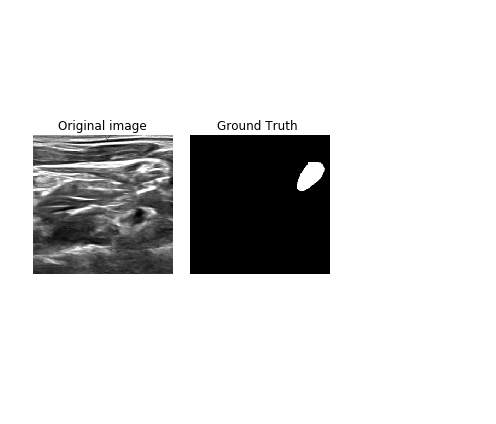

In [79]:
# Lets read some of our images
target = "./Data/1_1.tif"
mask = "./Data/1_1_mask.tif"


target = imread(target)
mask = imread(mask)
fig, axes = plt.subplots(1, 3, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(target,cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(mask,cmap='gray')
ax[1].set_title("Ground Truth ")

# Removes the axis labels...
for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [80]:
# Split the images into inputs and targets(mask)
def createFileList(myDir, format='mask.tif'):
    Listofmasks = []
    Listofinputs=[]
    
    for root, dirs, files in os.walk(myDir, topdown=True):
        for name in files:   
            if name.endswith(format):
                fullName = os.path.join(root, name)
                Listofmasks.append(fullName)
                
            else:
                fullName = os.path.join(root, name)
                Listofinputs.append(fullName)
                
           
    return Listofmasks,Listofinputs

Listofmasks,Listofinputs= createFileList('Data')
# Use natsort to sort the Listeof inputs and Listeofmasks so the inputs[i] matches the masks[i]
I=natsort.natsorted(Listofinputs,reverse=False)
GT=natsort.natsorted(Listofmasks,reverse=False)


In [ ]:
labels=[]
for target in GT:
    print(target)
    img_file = Image.open(target)
    # get original image parameters
    width, height = img_file.size
    # Save Greyscale values
    value = np.asarray(img_file.getdata(), dtype=np.int).reshape((img_file.size[1], img_file.size[0]))
    #Normalize the labels
    value=value//255
    print(np.unique(value))
    labels.append(value)
labels=np.asarray(labels)

In [ ]:
inputs=[]
for img in I:
    print(img)
    img_file = Image.open(img)
    # get original image parameters
    width, height = img_file.size
    # Save Greyscale values
    value = np.asarray(img_file.getdata(), dtype=np.int).reshape((img_file.size[1], img_file.size[0]))
    #print(np.unique(value))
    inputs.append(value)
inputs=np.asarray(inputs)
#Normalize the images.
inputs_mean = inputs.mean()
inputs_std = inputs.std()
inputs = (inputs - inputs_mean) / inputs_std

In [86]:
inputs.shape

(2323, 256, 256)

In [87]:
labels.shape

(2323, 256, 256)

In [88]:
#reshape the inputs and outputs to 4 dimensions (len(dataset),IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
inputs = np.expand_dims(inputs, axis=-1)
labels=np.expand_dims(labels, axis=-1)

In [89]:
inputs.shape

(2323, 256, 256, 1)

In [90]:
labels.shape

(2323, 256, 256, 1)

### Model design

#### Metrics

In [91]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [92]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

#### Model Architecture: U-Net

In [93]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
def get_unet():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2),padding='same') (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)
    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,mean_iou ])
    return model



modelU = get_unet()
modelU.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 8)  80          lambda_2[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 8)  584         conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_poolin

### Model Training& Evaluation

In [94]:
#Split the dataset into 60% for the training and 20% for the validation and 20% for the test set
n=int(len(inputs)*0.2)
X=inputs[:-n]
xtest=inputs[-n:]
Y=labels[:-n]
ytest=labels[-n:]

n=int(len(X)*0.2)
xtrain=X[:-n]
xval=X[-n:]
ytrain=Y[:-n]
yval=Y[-n:]

In [95]:
xtrain.shape

(1488, 256, 256, 1)

In [96]:
ytrain.shape

(1488, 256, 256, 1)

In [97]:
#To save the best model 
weight_saver = ModelCheckpoint('modelunit.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [98]:
#Fit the model
history = modelU.fit(xtrain, ytrain, epochs=15, validation_data=(xval, yval), batch_size=4, verbose=2,callbacks = [weight_saver, annealer])

Train on 1488 samples, validate on 371 samples
Epoch 1/15
 - 980s - loss: 0.1404 - acc: 0.9637 - dice_coef: 0.1156 - mean_iou: 0.0000e+00 - val_loss: 0.1004 - val_acc: 0.9656 - val_dice_coef: 0.1786 - val_mean_iou: 0.0000e+00
Epoch 2/15
 - 1003s - loss: 0.0828 - acc: 0.9691 - dice_coef: 0.3511 - mean_iou: 0.0084 - val_loss: 0.0881 - val_acc: 0.9694 - val_dice_coef: 0.3922 - val_mean_iou: 0.0324
Epoch 3/15
 - 1232s - loss: 0.0700 - acc: 0.9742 - dice_coef: 0.4559 - mean_iou: 0.0483 - val_loss: 0.0716 - val_acc: 0.9732 - val_dice_coef: 0.4114 - val_mean_iou: 0.0630
Epoch 4/15
 - 1039s - loss: 0.0607 - acc: 0.9774 - dice_coef: 0.5245 - mean_iou: 0.0753 - val_loss: 0.0642 - val_acc: 0.9762 - val_dice_coef: 0.4687 - val_mean_iou: 0.0876
Epoch 5/15
 - 1051s - loss: 0.0542 - acc: 0.9794 - dice_coef: 0.5711 - mean_iou: 0.0979 - val_loss: 0.0605 - val_acc: 0.9774 - val_dice_coef: 0.4940 - val_mean_iou: 0.1076
Epoch 6/15
 - 967s - loss: 0.0501 - acc: 0.9808 - dice_coef: 0.6031 - mean_iou: 0.1162

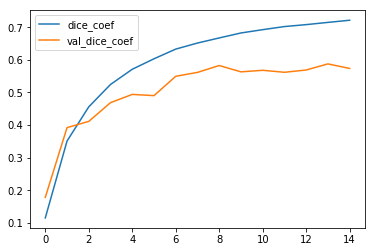

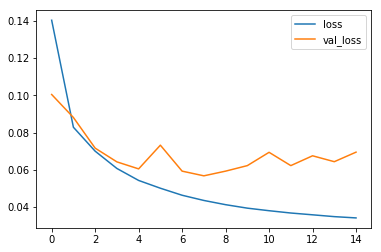

In [99]:
#Plot
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [101]:
 
modelU.load_weights('modelunit.h5')

In [113]:

# Predict on train, val and test
preds_train = modelU.predict(xtrain[:int(xtrain.shape[0]*0.9)], verbose=1)
preds_val = modelU.predict(xtrain[int(xtrain.shape[0]*0.9):], verbose=1)
preds_test = modelU.predict(xtest, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


464/464 [==============================] - 158s 340ms/step


Text(0.5,1,'y_pred: Predicted mask')

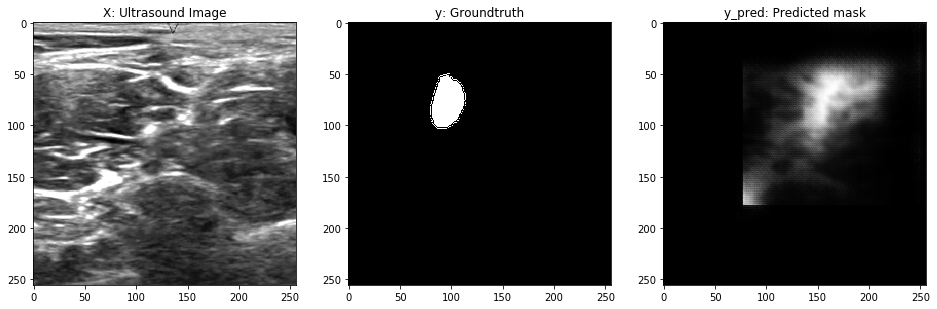

In [122]:
#Plot an example of predicted mask
idx = 40
x = xval[idx]


fig, ax = plt.subplots(1,3, figsize=(16, 16))
ax = ax.ravel()

ax[0].imshow(x[...,0], cmap='gray') 
ax[0].set_title('X: Ultrasound Image')

ax[1].imshow(ytrain[idx,...,0].squeeze(),cmap='gray')
ax[1].set_title('y: Groundtruth')

y_pred = modelU.predict(x[None]).squeeze()
ax[2].imshow(y_pred,cmap='gray')
ax[2].set_title('y_pred: Predicted mask')

In [114]:
#Evaluate the model on test set 
score = modelU.evaluate(xtest, ytest, verbose=0)
print(score) 

[0.10353244738332157, 0.9664345445304081, 0.16492211510395183, 0.0]


In [112]:
print(modelU.metrics_names)

['loss', 'acc', 'dice_coef', 'mean_iou']


In [115]:
#Save the model 
modelU.save("Ultrasound-Nerve-SegmetationUnet.tfl")